In [1]:
import numpy as np
import random
import seaborn as sb
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import bernoulli as bern, cauchy, norm, gamma, poisson as pois, binom, uniform, laplace, expon, trim_mean, iqr, beta, chi2_contingency, kstwobign, kstest, t, chi2, kruskal
from scipy.stats import anderson, shapiro, normaltest, weibull_min, geom, nbinom
import statistics
import scipy.stats as sts
from tqdm import tqdm
from matplotlib import rc
from math import pi, log, tan, sin, exp, sqrt
from scipy.optimize import minimize
import scipy.special
import statsmodels.api as sm
import pandas as pd
import time

1. Моделировать процесс восстановления (то есть точечный процесс с расстояниями между скачками с указанным распределением) с а) exp(λ) шагами, б) R[0, 1] распределением. Исследовать численно предельное распределение эксцесса и сравнить с распределением шага.

In [ ]:
def simulate_exp_process(lambda_, n_steps):
    interarrival_times = expon.rvs(scale=1/lambda_, size=n_steps)
    return np.cumsum(interarrival_times)

def simulate_uniform_process(n_steps):
    interarrival_times = uniform.rvs(0, 1, size=n_steps)
    return np.cumsum(interarrival_times)

def excess_distribution(arrival_times, n_samples):
    current_time = np.random.uniform(0, arrival_times[-1], size=n_samples)
    last_index = np.searchsorted(arrival_times, current_time, side='right') - 1
    last_index[last_index == -1] = 0
    last_time = arrival_times[last_index]
    excess = current_time - last_time
    return excess

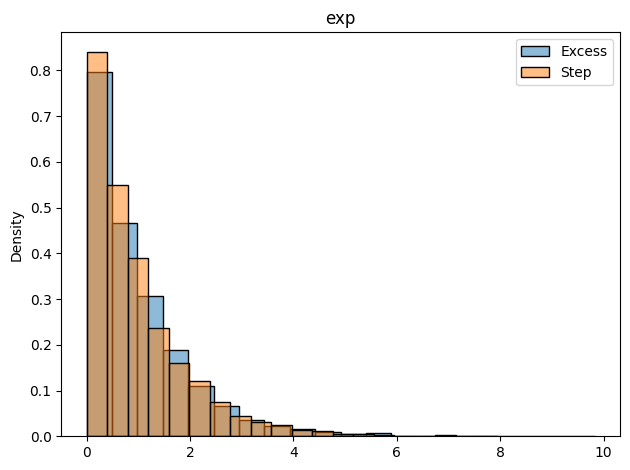

In [ ]:
n = 10000
lambda_ = 1
n_samples = 10000

exp_process = simulate_exp_process(lambda_, n)
uniform_process = simulate_uniform_process(n)

exp_excess = excess_distribution(exp_process, n_samples)
uniform_excess = excess_distribution(uniform_process, n_samples)


sb.histplot(exp_excess, stat="density", label='Excess', bins=20, alpha=0.5)
sb.histplot(expon.rvs(scale=1/lambda_, size=n_samples), stat="density", label='Step', bins=20, alpha=0.5)
plt.title('exp')
plt.legend()


plt.tight_layout()
plt.show()

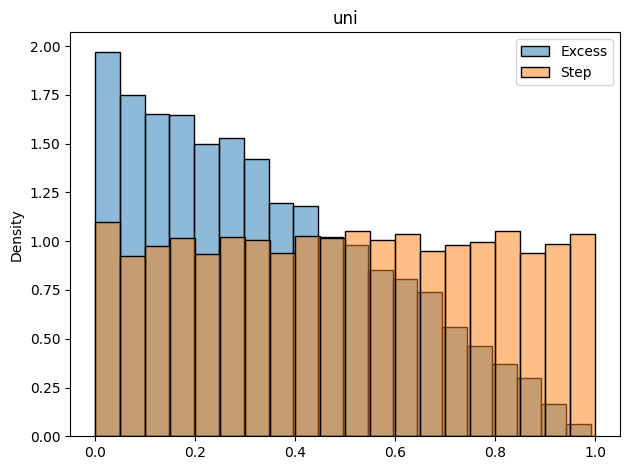

In [ ]:
sb.histplot(uniform_excess, stat="density", label='Excess', bins=20, alpha=0.5)
sb.histplot(uniform.rvs(0, 1, size=n_samples), stat="density", label='Step', bins=20, alpha=0.5)
plt.title('uni')
plt.legend()
plt.tight_layout()
plt.show()

2. Исследовать парадокс времени ожидания: моделировать а) пуассоновский поток с λ = 2 б) процесс с Gamma(2, 1/4) распределением между скачками в) процесс с R[0, 1] распределением между скачками.
Рассмотреть среднюю длину промежутка, накрывающего момент 100 и соотнести с математическим ожиданием между промежутками.

In [ ]:
def poisson_process(lambda_, max_time):
    interarrival_times = expon.rvs(scale=1/lambda_, size=int(max_time * lambda_ * 2))
    arrival_times = np.cumsum(interarrival_times)
    return arrival_times

def gamma_process(alpha, beta, max_time):
    interarrival_times = gamma.rvs(alpha, scale=1/beta, size=int(max_time / (alpha / beta) * 2))
    arrival_times = np.cumsum(interarrival_times)
    return arrival_times

def uniform_process(max_time):
    interarrival_times = uniform.rvs(0, 1, size=int(max_time * 2))
    arrival_times = np.cumsum(interarrival_times)
    return arrival_times

def interval(arrival_times, t):
    for i in range(len(arrival_times)-1):
        if arrival_times[i] <= 100 and arrival_times[i+1] >= 100:
            return arrival_times[i+1] - arrival_times[i]
    return 0

In [ ]:
max_time = 1000
t = 100
n = 1000

# Моделирование
poisson_intervals = [interval(poisson_process(2, max_time), t) for _ in range(n)]
gamma_intervals = [interval(gamma_process(2, 0.25, max_time), t) for _ in range(n)]
uniform_intervals = [interval(uniform_process(max_time), t) for _ in range(n)]

mean_poisson_interval = np.mean(poisson_intervals)
mean_gamma_interval = np.mean(gamma_intervals)
mean_uniform_interval = np.mean(uniform_intervals)

th_poisson_interval = 1/2
th_gamma_interval = 1/2
th_uniform_interval = 1/2

print(f"Средняя длина интервала для пуассоновского потока: {mean_poisson_interval}")
print(f"Теор ожидание: {th_poisson_interval}")

print(f"Средняя длина интервала для гамма-процесса: {mean_gamma_interval}")
print(f"Теор ожидание: {th_gamma_interval}")

print(f"Средняя длина интервала для равномерного процесса: {mean_uniform_interval}")
print(f"Теор ожидание: {th_uniform_interval}")

Средняя длина интервала для пуассоновского потока: 1.016637627815697
Теор ожидание: 0.5
Средняя длина интервала для гамма-процесса: 12.181866590034119
Теор ожидание: 0.5
Средняя длина интервала для равномерного процесса: 0.6754853299757495
Теор ожидание: 0.5


3. Исследуем условное свойство пуассоновского потока. Сгенерируйте точки пуассоновского потока а) на прямой б* ) на плоскости \\
и проверьте точки, попавшие на а) отрезок б* ) квадрат на равномерность.

In [5]:
from scipy.optimize import bisect
# Моделирование
def poisson_process_1(lambda_, n, int_):
    interarrival_times = expon.rvs(scale=1/lambda_, size=10*n)
    arr = np.cumsum(interarrival_times)
    n1 = len(np.where((arr >= int_[0]) & (arr <= int_[1]))[0])
    while n1 < n:
        np.append(interarrival_times, expon.rvs(scale=1/lambda_))
        np.append(arr, arr[:-1]+interarrival_times[:-1])
        n1 += int((arr[-1] >= int_[0]) & (arr[-1] <= int_[1]))
    return arr


def F(lambd, x, k):
    sum = 1
    f = 1
    for i in range(1, k):
        f *= i
        sum += (lambd*np.pi*x**2)**i / f
    return 1 - np.exp(-lambd * np.pi * x**2)*sum


def inverse_F(lambd, u, k):
    def equation(r):
        return F(lambd, r, k) - u
    initial_guess = 0.5
    r = bisect(equation, 0, 100)
    return r


def poisson_process_2(lambd, n, area):
    arr = []
    n1 = 0
    R = []
    for i in range(1, 60):
        u = np.random.uniform(0, 1)
        r = inverse_F(lambd, u, i)
        if 0 < r and r <= np.sqrt(2)*area[0][1]:
            R.append(r)

    for _ in range(5):
        for i in range(len(R)):
            phi = np.random.uniform(0, 2*np.pi)
            x = R[i] * np.cos(phi)
            y = R[i] * np.sin(phi)
            if (x >= area[0][0]) & (x <= area[0][1]) & (y >= area[1][0]) & (y <= area[1][1]):
                arr.append([x, y])
                n1 += 1
                if n1 == n:
                    return arr

# Проверка равномерности
def check_uniformity_1d(arrival_times, int_):
    idxs = np.where((arrival_times >= int_[0]) & (arrival_times <= int_[1]))[0]
    points_in_interval = arrival_times[idxs]
    normalized_points = np.array(points_in_interval) / (int_[1] - int_[0])
    return kstest(normalized_points, 'uniform').pvalue

def check_uniformity_2d(array, area):
    array = np.array(array)
    x_normalized = array[:, 0] / (area[0][1] - area[0][0])
    y_normalized = array[:, 1] / (area[1][1] - area[1][0])
    ks_x = kstest(x_normalized, 'uniform').pvalue > 0.05
    ks_y = kstest(y_normalized, 'uniform').pvalue > 0.05
    return kstest(x_normalized, 'uniform').pvalue , kstest(y_normalized, 'uniform').pvalue

0.332629507307171


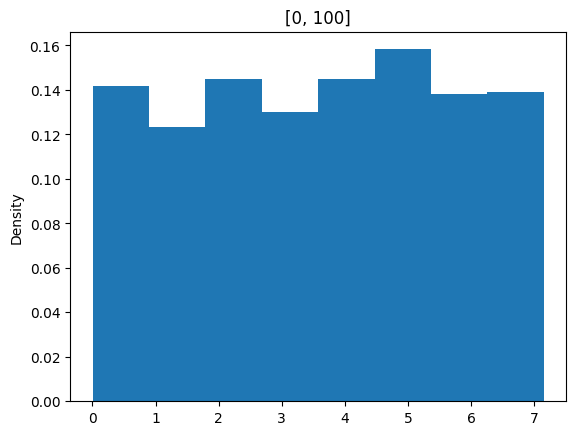

In [6]:
lambda_ = 2
n = 150

# на прямой
int_ = [0, 100]
arrival_times_1d = poisson_process_1(lambda_, n, int_)
uniformity_1d = check_uniformity_1d(arrival_times_1d, int_)


print(uniformity_1d)


plt.hist(np.array(arrival_times_1d) / (int_[1] - int_[0]), bins=8, density=True)
plt.title(f'{int_}')
plt.ylabel('Density')
plt.show()



4. На картинке приведено расположений ели на участке хвойного леса. Считая, что они образуют дву-
мерный одномерный пуассоновский поток, оценить число деревьев на небольшом участке и отсюда а)

оценить число деревьев на картинке б) построить доверительный интервал (асимптотический) для этого
количества. Повторить процедуру повторно и сравнить результаты.

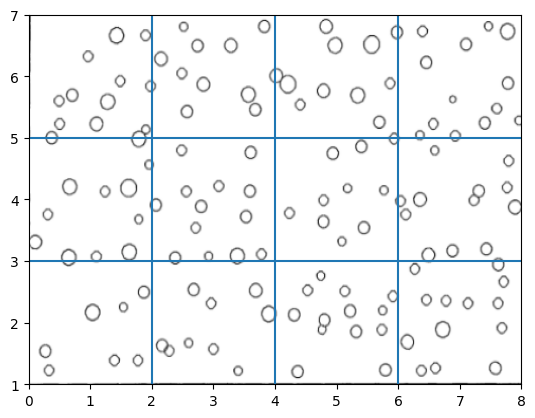

In [ ]:
datafile = '/content/trees.png'
img = plt.imread(datafile)
plt.imshow(img, zorder=0, extent=[0.0, 8.0, 1.0, 7.0])
plt.hlines(y=np.arange(3, 7, 2), xmin=0, xmax=8)
plt.vlines(x=np.arange(2, 7, 2), ymin=1, ymax=7)
plt.show()

2 строка 2 столбец: 13 деревьев $⇒$ оценка для числа деревьев: $12 ⋅ 13 = 156$
\
на самом деле - 133

$
X \sim Poisson(\lambda)\\
\sqrt{n}\frac{\overline{X} - {\lambda}}{\widehat{\sigma}} \sim \mathcal{N}(0, 1) \\
\sqrt{n}\frac{\overline{X} - {\lambda}}{\widehat{\sigma}} \in (z_{\alpha/2}, z_{1-\alpha/2}) \\
\lambda \in (\overline{X} - n^{-1/2}{\widehat{\sigma}} z_{1-\alpha/2}, \overline{X} + n^{-1/2}{\widehat{\sigma}} z_{1-\alpha/2})
$

In [ ]:
sigma=np.sqrt(156)
n=300
X=sts.poisson(mu=133).rvs(size=n)
X.mean()-n**(-1/2)*sigma*sts.norm().ppf(1 - 0.05/2), X.mean()+n**(-1/2)*sigma*sts.norm().ppf(1 - 0.05/2)

(131.80664987113562, 134.63335012886438)

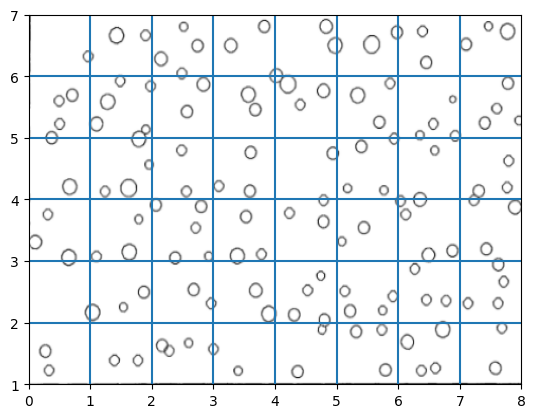

In [ ]:
datafile = '/content/trees.png'
img = plt.imread(datafile)
plt.imshow(img, zorder=0, extent=[0.0, 8.0, 1.0, 7.0])
plt.hlines(y=np.arange(2, 7, 1), xmin=0, xmax=8)
plt.vlines(x=np.arange(1, 8, 1), ymin=1, ymax=7)
plt.show()

$3 \cdot (6 \cdot 8) = 144 $

In [ ]:
sigma=np.sqrt(144)
n=300
X=sts.poisson(mu=133).rvs(size=n)
X.mean()-n**(-1/2)*sigma*sts.norm().ppf(1 - 0.05/2), X.mean()+n**(-1/2)*sigma*sts.norm().ppf(1 - 0.05/2)

(131.9920971191086, 134.7079028808914)

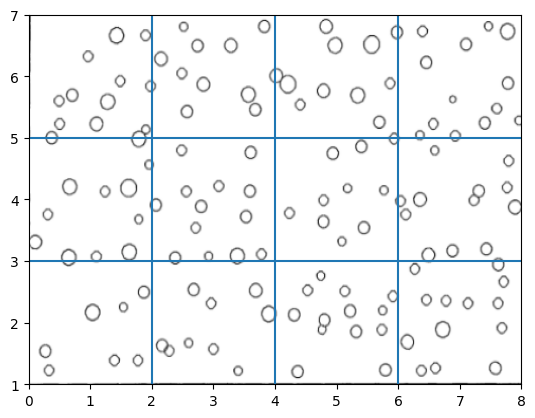

In [ ]:
datafile = '/content/trees.png'
img = plt.imread(datafile)
plt.imshow(img, zorder=0, extent=[0.0, 8.0, 1.0, 7.0])
plt.hlines(y=np.arange(3, 7, 2), xmin=0, xmax=8)
plt.vlines(x=np.arange(2, 7, 2), ymin=1, ymax=7)
plt.show()

$
X \sim Poisson(\lambda), Y \sim Poisson(\mu) \\
H_0: \lambda = \mu \\
H_1: \lambda \neq \mu \\
L(x, y; \lambda, \mu) = \frac{\lambda^x}{x!}e^{-\lambda} \frac{\mu^y}{y!}e^{-\mu} \\
lnL = C + x ln\lambda - \lambda + y ln\mu -\mu \\
\frac{\partial lnL}{\partial \lambda} = \frac{x}{\lambda} - 1 = 0 ⇒ \\
\widehat{\lambda} = x \\
\widehat{\mu} = y \\
lnL_0 = C + (x + y) ln\mu - 2\mu \\
\frac{\partial lnL_0}{\partial \mu} = \frac{x+y}{\mu} - 2 = 0 ⇒ \widehat{\mu}_0 = \frac{x+y}{2}
$

$
\Lambda = \frac{L}{L_0}  = \frac{\frac{x^x}{x!}e^{-x} \frac{y^y}{y!}e^{-y}}{\frac{(\frac{x+y}{2})^{x+y}}{x!y!} e^{-(x+y)}} = \frac{x^x y^y}{((x+y)/2)^{x+y}} \\
\text{При } H_0: 2 ln\Lambda \to \xi \sim \chi_1^2
$

2 строчка 1 столбец и последняя ячейка

In [ ]:
x = 11
y = 13
2 * np.log((x ** x) * (y ** y) / (((x + y) / 2) ** (x + y)))

0.1668601057400923

In [ ]:
sts.chi2(df=1).ppf(1 - 0.05)

3.841458820694124